PostgreSQL connection is closed
PostgreSQL connection is closed



XGBoost



Score :0.9117402164862615





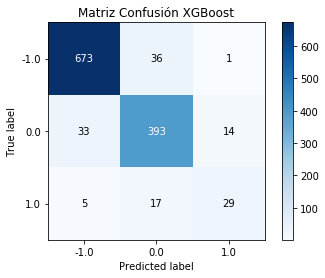

In [13]:
import psycopg2
import sys, nltk, re, string, heapq, gensim

from psycopg2 import Error
import math
from matplotlib import pyplot as plt
import pandas as pd
import pandas.io.sql as sqlio

import scikitplot as skplt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def crearConexion():
    
    connection = psycopg2.connect(user = "m.soto.montesinos",
                                      password = "1234",
                                      host = "127.0.0.1",
                                      port = "5432",
                                      database = "twitterBBVA")

    return connection

def obtenerTweets(tabla):

    try:
        
        connection = crearConexion()
        query = """
                SELECT clasificacion, sentimiento, caso_villarejo, futbol, mayusculas,
                lista_palabras_positivas, lista_palabras_negativas, emoticonos_buenos,
                emoticonos_malos FROM %s;
                """ % (tabla)
        
        tweets = sqlio.read_sql_query(query, connection)
        
    except (Exception, psycopg2.DatabaseError) as error :
    
        print ("Error obteniendo los datos", error)
    
    finally:
        
        if (connection):
            
            connection.close()
            print("PostgreSQL connection is closed")

    return tweets


def main():
    
    training_tweets = obtenerTweets("training_set")
    testing_tweets = obtenerTweets("testing_set")
    
    x_training_tweets = training_tweets.drop(columns = ['clasificacion'])
    y_training_tweets = training_tweets['clasificacion']
    x_testing_tweets = testing_tweets.drop(columns = ['clasificacion'])
    y_testing_tweets = testing_tweets['clasificacion']
    
    data_dmatrix = xgb.DMatrix(data = x_training_tweets,
                               label = y_training_tweets)
    
    colsample_bytree = np.linspace(0.5, 1.0, num=5)
    max_depth = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
    gamma = [int(x) for x in np.linspace(start = 0, stop = 10, num = 11)]
    n_estimators = [int(x) for x in np.linspace(start = 0, stop = 10000, num = 101)]
        
    random_grid = {'colsample_bytree' : colsample_bytree,
                   'max_depth' : max_depth,
                   'gamma': gamma,
                   'n_estimators': n_estimators
                   }
    
    modelo_xgboost = xgb.XGBClassifier(objective = 'multi:softmax',
                                       num_class = 3)
        
    #Buscamos todas las combinaciones posibles
    #rf_random = RandomizedSearchCV(estimator = modelo_xgboost, 
    #                               param_distributions = random_grid, 
    #                               n_iter = 20)
    
    #Entrenamos el modelo con las posibles combinaciones.
    #rf_random.fit(x_training_tweets, y_training_tweets)
    
    #Obtenemos los parametros con mejor resultado
    #print(rf_random.best_params_)
    #{'n_estimators': 5700, 'max_depth': 9, 'gamma': 2, 'colsample_bytree': 0.75}
    
    modelo_xgboost = xgb.XGBClassifier(objective = 'multi:softmax',
                                       num_class = 3,
                                      n_estimators = 5000,
                                      max_depth = 9,
                                      gamma = 2,
                                      colsample_bytree = 0.75)
        
    modelo_xgboost.fit(x_training_tweets, y_training_tweets)
    
    score = modelo_xgboost.score(x_testing_tweets, y_testing_tweets)
    predicciones = modelo_xgboost.predict(x_testing_tweets)
    
    print('\n\n')
    print("XGBoost")
    print('\n\n')
    print("Score :" + str(score))
    print('\n\n')
    
    skplt.metrics.plot_confusion_matrix(y_testing_tweets,
                                        predicciones,
                                        title = "Matriz Confusión XGBoost",
                                        normalize=False)
    plt.show()
    
if __name__ == '__main__':
    main()





